In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from functions import (Calculate_CFD, create_position, plot_gaussian, get_gaussian_params,
                       calculate_gaussian_center, calculate_slope_y_intercept, continuous_delay)

In [4]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

#non_normalized_data = np.load(os.path.join(dir,'pulsos_Na22_filt_norm_practica_polyfit_sin_normalizar.npz'))['data']
normalized_data = np.load(os.path.join(dir, 'Na22_test_val.npz'))['data']

In [15]:
fraction = 0.2    # Fraction to attenuate pulse for CFD
shift = 6         # Delay for CFD 
threshold = 0.02  # Threshold for relative Leading Edge
t_shift = 1     
nbins = 71
time_step = 0.2   # In ns
positions = np.array([0.4, 0.2, 0.0, -0.2, -0.4])

In [16]:
DATA_00 = normalized_data 
DATA_02 = create_position(DATA_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift)
DATA_20 = create_position(DATA_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift)
DATA_04 = create_position(DATA_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift))
DATA_40 = create_position(DATA_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift))

# **CFD**

V20: CENTROID(ns) = 0.1836 +/- 0.00090  FWHM(ns) = 0.2803 +/- 0.00099
V00: CENTROID(ns) = -0.0002 +/- 0.00087  FWHM(ns) = 0.2839 +/- 0.00096
V02: CENTROID(ns) = -0.1947 +/- 0.00065  FWHM(ns) = 0.2733 +/- 0.00071


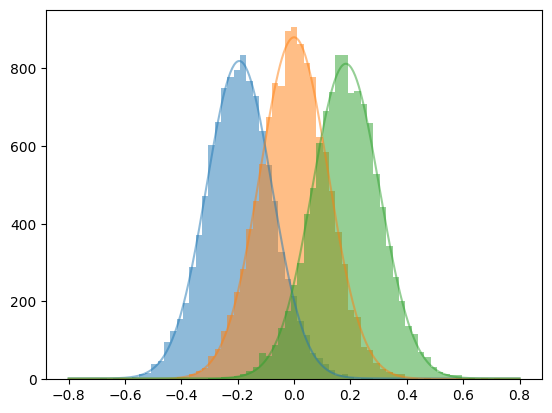

In [17]:
data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA.npz'))['data']
data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA.npz'))['data']
data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA.npz'))['data']

timestamps_CFD_dec0_DATA_00 = Calculate_CFD(data_55[:, :300, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_00 = Calculate_CFD(data_55[:, :300, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_02 = Calculate_CFD(data_28[:, :300, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_02 = Calculate_CFD(data_28[:, :300, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_20 = Calculate_CFD(data_82[:, :300, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_20 = Calculate_CFD(data_82[:, :300, 1], fraction = fraction, shift = shift, time_step = time_step)

TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20

centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 
plot_gaussian(TOF_CFD_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

In [10]:
timestamps_CFD_dec0_DATA_00 = Calculate_CFD(DATA_00[:, :, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_00 = Calculate_CFD(DATA_00[:, :, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_02 = Calculate_CFD(DATA_02[:, :, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_02 = Calculate_CFD(DATA_02[:, :, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_20 = Calculate_CFD(DATA_20[:, :, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_20 = Calculate_CFD(DATA_20[:, :, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_04 = Calculate_CFD(DATA_04[:, :, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_04 = Calculate_CFD(DATA_04[:, :, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_40 = Calculate_CFD(DATA_40[:, :, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_40 = Calculate_CFD(DATA_40[:, :, 1], fraction = fraction, shift = shift, time_step = time_step)


TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20
TOF_CFD_V04 = timestamps_CFD_dec0_DATA_04 - timestamps_CFD_dec1_DATA_04
TOF_CFD_V40 = timestamps_CFD_dec0_DATA_40 - timestamps_CFD_dec1_DATA_40

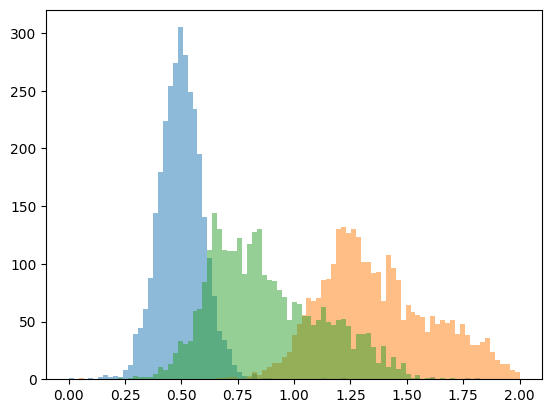

In [11]:
plt.hist(timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00, bins = nbins + 20, alpha = 0.5, range = [0,2]);
plt.hist(timestamps_CFD_dec0_DATA_00 - 14, bins = nbins + 20, alpha = 0.5, range = [0,2]); 
plt.hist(timestamps_CFD_dec1_DATA_00 - 14, bins = nbins + 20, alpha = 0.5, range = [0,2]);

V40: CENTROID(ns) = 0.3997 +/- 0.00087  FWHM(ns) = 0.2148 +/- 0.00093
V20: CENTROID(ns) = 0.1994 +/- 0.00077  FWHM(ns) = 0.2154 +/- 0.00082
V00: CENTROID(ns) = -0.0006 +/- 0.00064  FWHM(ns) = 0.2146 +/- 0.00069
V02: CENTROID(ns) = -0.2005 +/- 0.00071  FWHM(ns) = 0.2141 +/- 0.00076
V04: CENTROID(ns) = -0.4006 +/- 0.00078  FWHM(ns) = 0.2142 +/- 0.00084



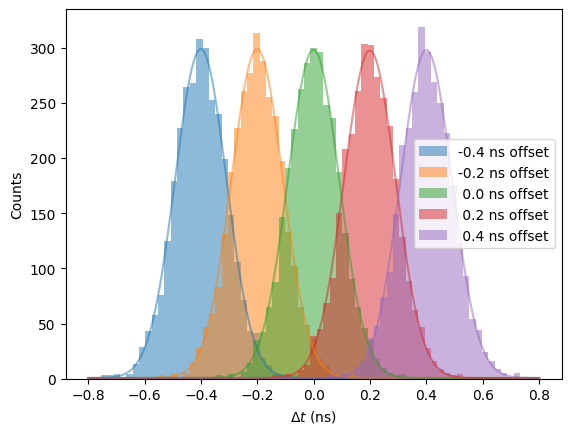

In [12]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_CFD_V04, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V40, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins)

params_V04, errors_V04 = get_gaussian_params(TOF_CFD_V04, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_CFD_V40, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [13]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a = np.random.choice(np.arange(0, TOF_CFD_V00.shape[0]), size = TOF_CFD_V00.shape[0], replace = True)
    
    centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,a], nbins = nbins, limits = 3) 
    params_V04, errors_V04 = get_gaussian_params(TOF_CFD_V04[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V40, errors_V40 = get_gaussian_params(TOF_CFD_V40[a], centroid_V00, range = 0.8, nbins = nbins)
    
    resolution = np.mean((params_V40[3], params_V20[3], params_V00[3], params_V02[3], params_V04[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V40[2], params_V20[2], params_V00[2], params_V02[2], params_V04[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_CFD_V02 - centroid_V00[:, np.newaxis] + time_step*t_shift))
    error_V00 = abs((TOF_CFD_V00 - centroid_V00[:, np.newaxis]))
    error_V20 = abs((TOF_CFD_V20 - centroid_V00[:, np.newaxis] - time_step*t_shift))
    error_V04 = abs((TOF_CFD_V04 - centroid_V00[:, np.newaxis] + 2*time_step*t_shift))
    error_V40 = abs((TOF_CFD_V40 - centroid_V00[:, np.newaxis] - 2*time_step*t_shift))

    Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)


/home/josea/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean CTR:  214.51338870951776
Std CTR:  4.446616025139725
Mean bias:  0.7238140490007865
Std bias:  0.49781277520875705
Mean MAE:  84.4478461110674
Std MAE:  0.03460463965847817


# **RELATIVE LEADING EDGE** 

In [14]:
timestamps_RLED_dec0_DATA_00_list = []
timestamps_RLED_dec0_DATA_02_list = []
timestamps_RLED_dec0_DATA_20_list = []
timestamps_RLED_dec0_DATA_04_list = []
timestamps_RLED_dec0_DATA_40_list = []

timestamps_RLED_dec1_DATA_00_list = []
timestamps_RLED_dec1_DATA_02_list = []
timestamps_RLED_dec1_DATA_20_list = []
timestamps_RLED_dec1_DATA_04_list = []
timestamps_RLED_dec1_DATA_40_list = []


for i in range(DATA_00.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_00[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_00[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_00_list.append(timestamp_dec1)

for i in range(DATA_02.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_02[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_02[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_02_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_02_list.append(timestamp_dec1)

for i in range(DATA_20.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_20[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_20[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_20_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_20_list.append(timestamp_dec1)

for i in range(DATA_04.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_04[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_04[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_04_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_04_list.append(timestamp_dec1)

for i in range(DATA_40.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_40[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_40[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_40_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_40_list.append(timestamp_dec1)

timestamps_RLED_dec0_DATA_00 = np.array(timestamps_RLED_dec0_DATA_00_list)
timestamps_RLED_dec0_DATA_02 = np.array(timestamps_RLED_dec0_DATA_02_list)
timestamps_RLED_dec0_DATA_20 = np.array(timestamps_RLED_dec0_DATA_20_list)
timestamps_RLED_dec0_DATA_04 = np.array(timestamps_RLED_dec0_DATA_04_list)
timestamps_RLED_dec0_DATA_40 = np.array(timestamps_RLED_dec0_DATA_40_list)

timestamps_RLED_dec1_DATA_00 = np.array(timestamps_RLED_dec1_DATA_00_list)
timestamps_RLED_dec1_DATA_02 = np.array(timestamps_RLED_dec1_DATA_02_list)
timestamps_RLED_dec1_DATA_20 = np.array(timestamps_RLED_dec1_DATA_20_list)
timestamps_RLED_dec1_DATA_04 = np.array(timestamps_RLED_dec1_DATA_04_list)
timestamps_RLED_dec1_DATA_40 = np.array(timestamps_RLED_dec1_DATA_40_list)

In [15]:
TOF_RLED_V00 = timestamps_RLED_dec0_DATA_00 - timestamps_RLED_dec1_DATA_00
TOF_RLED_V02 = timestamps_RLED_dec0_DATA_02 - timestamps_RLED_dec1_DATA_02
TOF_RLED_V20 = timestamps_RLED_dec0_DATA_20 - timestamps_RLED_dec1_DATA_20
TOF_RLED_V04 = timestamps_RLED_dec0_DATA_04 - timestamps_RLED_dec1_DATA_04
TOF_RLED_V40 = timestamps_RLED_dec0_DATA_40 - timestamps_RLED_dec1_DATA_40

V40: CENTROID(ns) = 0.3999 +/- 0.00078  FWHM(ns) = 0.2130 +/- 0.00083
V20: CENTROID(ns) = 0.2001 +/- 0.00060  FWHM(ns) = 0.2147 +/- 0.00064
V00: CENTROID(ns) = 0.0000 +/- 0.00083  FWHM(ns) = 0.2159 +/- 0.00089
V02: CENTROID(ns) = -0.1999 +/- 0.00104  FWHM(ns) = 0.2169 +/- 0.00111
V04: CENTROID(ns) = -0.3996 +/- 0.00099  FWHM(ns) = 0.2157 +/- 0.00106



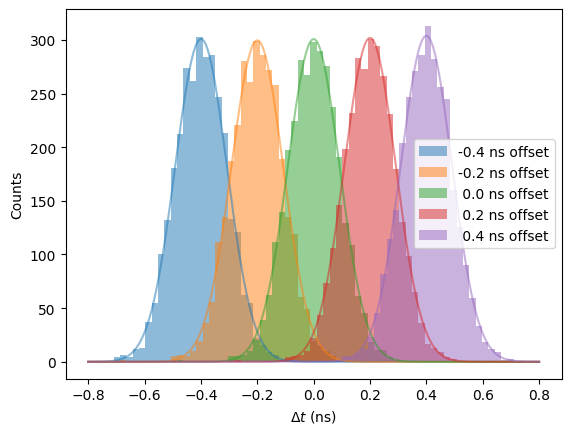

In [16]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_RLED_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_RLED_V04, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V40, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins)


params_V04, errors_V04 = get_gaussian_params(TOF_RLED_V04, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_RLED_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_RLED_V20, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_RLED_V40, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [17]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a = np.random.choice(np.arange(0, TOF_RLED_V00.shape[0]), size = TOF_RLED_V00.shape[0], replace = True)
    
    centroid_V00 = calculate_gaussian_center(TOF_RLED_V00[None, a], nbins = nbins, limits = 3) 
    params_V04, errors_V04 = get_gaussian_params(TOF_RLED_V04[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V02[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_RLED_V00[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_RLED_V20[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V40, errors_V40 = get_gaussian_params(TOF_RLED_V40[a], centroid_V00, range = 0.8, nbins = nbins)
    
    resolution = np.mean((params_V40[3], params_V20[3], params_V00[3], params_V02[3], params_V04[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V40[2], params_V20[2], params_V00[2], params_V02[2], params_V04[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_RLED_V02 - centroid_V00[:, np.newaxis] + time_step*t_shift))
    error_V00 = abs((TOF_RLED_V00 - centroid_V00[:, np.newaxis]))
    error_V20 = abs((TOF_RLED_V20 - centroid_V00[:, np.newaxis] - time_step*t_shift))
    error_V04 = abs((TOF_RLED_V04 - centroid_V00[:, np.newaxis] + 2*time_step*t_shift))
    error_V40 = abs((TOF_RLED_V40 - centroid_V00[:, np.newaxis] - 2*time_step*t_shift))

    Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)


Mean CTR:  214.893826746118
Std CTR:  4.04766007860244
Mean bias:  0.658361755619779
Std bias:  0.4396466070750142
Mean MAE:  82.215248993368
Std MAE:  0.03204521008258263


# **D-LED**

In [18]:
DATA_00 = non_normalized_data 
DATA_02 = create_position(DATA_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift)
DATA_20 = create_position(DATA_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift)
DATA_04 = create_position(DATA_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift))
DATA_40 = create_position(DATA_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift))


NameError: name 'non_normalized_data' is not defined

In [15]:
timestamps_DLED_dec0_DATA_00_list = []
timestamps_DLED_dec0_DATA_02_list = []
timestamps_DLED_dec0_DATA_20_list = []
timestamps_DLED_dec0_DATA_04_list = []
timestamps_DLED_dec0_DATA_40_list = []

timestamps_DLED_dec1_DATA_00_list = []
timestamps_DLED_dec1_DATA_02_list = []
timestamps_DLED_dec1_DATA_20_list = []
timestamps_DLED_dec1_DATA_04_list = []
timestamps_DLED_dec1_DATA_40_list = []


for i in range(DATA_00.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_00[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_00[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_00_list.append(timestamp_dec1)

for i in range(DATA_02.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_02[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_02[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_02_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_02_list.append(timestamp_dec1)

for i in range(DATA_20.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_20[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_20[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_20_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_20_list.append(timestamp_dec1)

for i in range(DATA_04.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_04[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_04[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_04_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_04_list.append(timestamp_dec1)

for i in range(DATA_40.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(DATA_40[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(DATA_40[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_40_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_40_list.append(timestamp_dec1)

timestamps_DLED_dec0_DATA_00 = np.array(timestamps_DLED_dec0_DATA_00_list)
timestamps_DLED_dec0_DATA_02 = np.array(timestamps_DLED_dec0_DATA_02_list)
timestamps_DLED_dec0_DATA_20 = np.array(timestamps_DLED_dec0_DATA_20_list)
timestamps_DLED_dec0_DATA_04 = np.array(timestamps_DLED_dec0_DATA_04_list)
timestamps_DLED_dec0_DATA_40 = np.array(timestamps_DLED_dec0_DATA_40_list)

timestamps_DLED_dec1_DATA_00 = np.array(timestamps_DLED_dec1_DATA_00_list)
timestamps_DLED_dec1_DATA_02 = np.array(timestamps_DLED_dec1_DATA_02_list)
timestamps_DLED_dec1_DATA_20 = np.array(timestamps_DLED_dec1_DATA_20_list)
timestamps_DLED_dec1_DATA_04 = np.array(timestamps_DLED_dec1_DATA_04_list)
timestamps_DLED_dec1_DATA_40 = np.array(timestamps_DLED_dec1_DATA_40_list)

# %%
TOF_DLED_V00 = timestamps_DLED_dec0_DATA_00 - timestamps_DLED_dec1_DATA_00
TOF_DLED_V02 = timestamps_DLED_dec0_DATA_02 - timestamps_DLED_dec1_DATA_02
TOF_DLED_V20 = timestamps_DLED_dec0_DATA_20 - timestamps_DLED_dec1_DATA_20
TOF_DLED_V04 = timestamps_DLED_dec0_DATA_04 - timestamps_DLED_dec1_DATA_04
TOF_DLED_V40 = timestamps_DLED_dec0_DATA_40 - timestamps_DLED_dec1_DATA_40

V40: CENTROID(ns) = 0.3994 +/- 0.00023  FWHM(ns) = 0.2203 +/- 0.00025
V20: CENTROID(ns) = 0.1995 +/- 0.00033  FWHM(ns) = 0.2201 +/- 0.00036
V00: CENTROID(ns) = -0.0006 +/- 0.00043  FWHM(ns) = 0.2199 +/- 0.00046
V02: CENTROID(ns) = -0.2006 +/- 0.00033  FWHM(ns) = 0.2194 +/- 0.00036
V04: CENTROID(ns) = -0.4006 +/- 0.00029  FWHM(ns) = 0.2195 +/- 0.00031



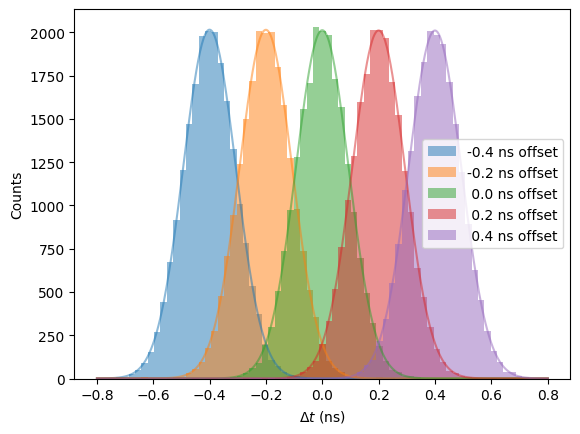

In [16]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_DLED_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_DLED_V04, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V40, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins)


params_V04, errors_V04 = get_gaussian_params(TOF_DLED_V04, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_DLED_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_DLED_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_DLED_V20, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_DLED_V40, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [17]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a = np.random.choice(np.arange(0, TOF_DLED_V00.shape[0]), size = TOF_DLED_V00.shape[0], replace = True)
    
    centroid_V00 = calculate_gaussian_center(TOF_DLED_V00[None,a], nbins = nbins, limits = 3) 
    params_V04, errors_V04 = get_gaussian_params(TOF_DLED_V04[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V02, errors_V02 = get_gaussian_params(TOF_DLED_V02[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_DLED_V00[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_DLED_V20[a], centroid_V00, range = 0.8, nbins = nbins)
    params_V40, errors_V40 = get_gaussian_params(TOF_DLED_V40[a], centroid_V00, range = 0.8, nbins = nbins)
    
    resolution = np.mean((params_V40[3], params_V20[3], params_V00[3], params_V02[3], params_V04[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V40[2], params_V20[2], params_V00[2], params_V02[2], params_V04[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_DLED_V02 - centroid_V00[:, np.newaxis] + time_step*t_shift))
    error_V00 = abs((TOF_DLED_V00 - centroid_V00[:, np.newaxis]))
    error_V20 = abs((TOF_DLED_V20 - centroid_V00[:, np.newaxis] - time_step*t_shift))
    error_V04 = abs((TOF_DLED_V04 - centroid_V00[:, np.newaxis] + 2*time_step*t_shift))
    error_V40 = abs((TOF_DLED_V40 - centroid_V00[:, np.newaxis] - 2*time_step*t_shift))

    Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)

Mean CTR:  219.73657935877145
Std CTR:  1.727328153253324
Mean bias:  0.563088203239583
Std bias:  0.27983093538186077
Mean MAE:  84.53024621743594
Std MAE:  0.004776938138821566


# **ML**

In [18]:
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions'
test_dec0 = np.load(os.path.join(dir, 'test_dec0_Na22_KAN.npz'))['data']
test_dec1 = np.load(os.path.join(dir, 'test_dec1_Na22_KAN.npz'))['data']

In [19]:
# Calculate TOF
TOF = test_dec0 - test_dec1

size = int(test_dec0.shape[0]/5)
TOF_V02 = TOF[:size] 
TOF_V00 = TOF[size : 2*size] 
TOF_V20 = TOF[2*size :3*size] 
TOF_V04 = TOF[3*size :4*size] 
TOF_V40 = TOF[4*size:] 

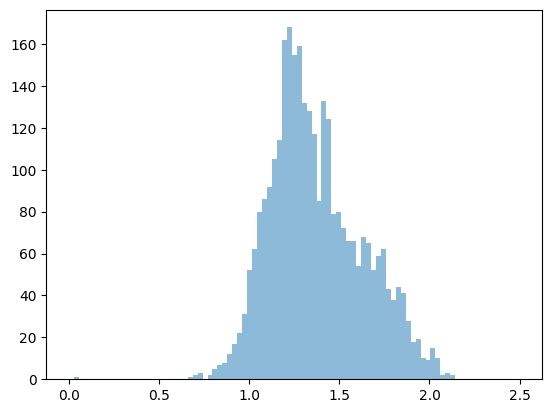

In [55]:
#plt.hist(test_dec0[size : 2*size] , bins = nbins, alpha = 0.5, range = [-0.2, 1]);
plt.hist(timestamps_CFD_dec0_DATA_00 - 14, bins = nbins + 20, alpha = 0.5, range = [0,2.5]);  

In [58]:
from scipy.signal import find_peaks
# ML peaks
histogE, binsE = np.histogram(test_dec0[size : 2*size], bins = nbins, range = [-0.2,1]);
peaks = find_peaks(histogE, height = 50)[0]
pos_peaks = (binsE[peaks + 1] + binsE[peaks])/2
print(pos_peaks)

#CFD peaks
histogE, binsE = np.histogram(timestamps_CFD_dec0_DATA_00-14, bins = nbins, range = [0,2.5]);
peaks = find_peaks(histogE, height = 20)[0]
pos_peaks = (binsE[peaks + 1] + binsE[peaks])/2
print(pos_peaks)

[0.1971831  0.28169012 0.4169014  0.5690141  0.70422536]
[1.21478873 1.42605634 1.63732394 1.74295775 1.84859155]
